In [18]:
import json
file = open('data.json', 'r', encoding='utf-8')
data = json.load(file)

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import koreanize_matplotlib

In [20]:
import pandas as pd

question_records = []

# Iterate through each student's stat data
for stat_id, stat_data in data["statistics"].items():
    gender = stat_data["gender"]
    grade = stat_data["grade"]
    total_score = stat_data["totalScore"]
    questions = stat_data.get("question", [])

    for q in questions:
        if q:
            question_records.append({
                "student_id": stat_id,
                "Gender": gender,
                "Grade": grade,
                "Question": q["question"],
                "Answer": q["answer"],
                "Type": q["type"],
                "TotalScore": total_score
            })

# Convert to DataFrame
question_df = pd.DataFrame(question_records)

In [21]:
# Parse personal data
combined_rows = []

# Match entries by totalScore and grade
for stat_id, stat_data in data["statistics"].items():
    for stu_id, stu_data in data["students"].items():
        if (stat_data["grade"] == stu_data["studentGrade"] and
            stat_data["totalScore"] == stu_data["totalScore"] and
                stat_data["scores"] == stu_data["scores"]):

            row = {
                "ID_stat": stat_id,
                "ID_student": stu_id,
                "Gender": stat_data.get("gender"),
                "Grade": stat_data.get("grade"),
                "SurveyTime": stat_data.get("date"),
                "ParsedTime": stu_data.get("parsedDate"),
                "TotalScore": stat_data.get("totalScore")
            }
            # Include category scores
            row.update(stat_data["scores"])
            combined_rows.append(row)
            break

# Convert to DataFrame
df_combined = pd.DataFrame(combined_rows)

# Print final table
print(df_combined.to_string(index=False))

             ID_stat           ID_student Gender Grade SurveyTime         ParsedTime  TotalScore  불안 및 우울 문제  심리외상 문제  외현화 문제  자살 및 위기 문제  학교생활적응 문제
-ORO3afgAtqlPL9nX2G5 -ORO3afb_TN98Kofxvo2   girl   2학년  5월 29일 7시  2025-5-29 7:45:26          80          24       14       9          18         15
-ORO42E6AZfcaferUZKV -ORO42E2e1pii41jNKbl   girl   1학년  5월 29일 7시  2025-5-29 7:47:23           0           0        0       0           0          0
-ORO47TnvMiiv0gHk-3i -ORO47TjdZ_5jV43PcXi    boy   2학년  5월 29일 7시  2025-5-29 7:47:45           4           0        0       2           0          2
-ORO4eKQsY3AF-Cji_Rk -ORO4eKMBcwY5NWfbf_9   girl   2학년  5월 29일 7시   2025-5-29 7:50:3           7           6        0       0           0          1
-ORO5pZyLjX3rRv7QpeL -ORO5pZuPnJomqtF8JFn    boy   1학년  5월 29일 7시  2025-5-29 7:55:12          19           9        4       3           0          3
-ORO5zoeU-yf5-uvZosn -ORO5zobt7VtPF24uHBx    boy   1학년  5월 29일 7시  2025-5-29 7:55:54           9          

In [22]:
pivot_df = question_df.pivot(
    index="student_id", columns="Question", values="Answer")
correlation_matrix = pivot_df.corr()

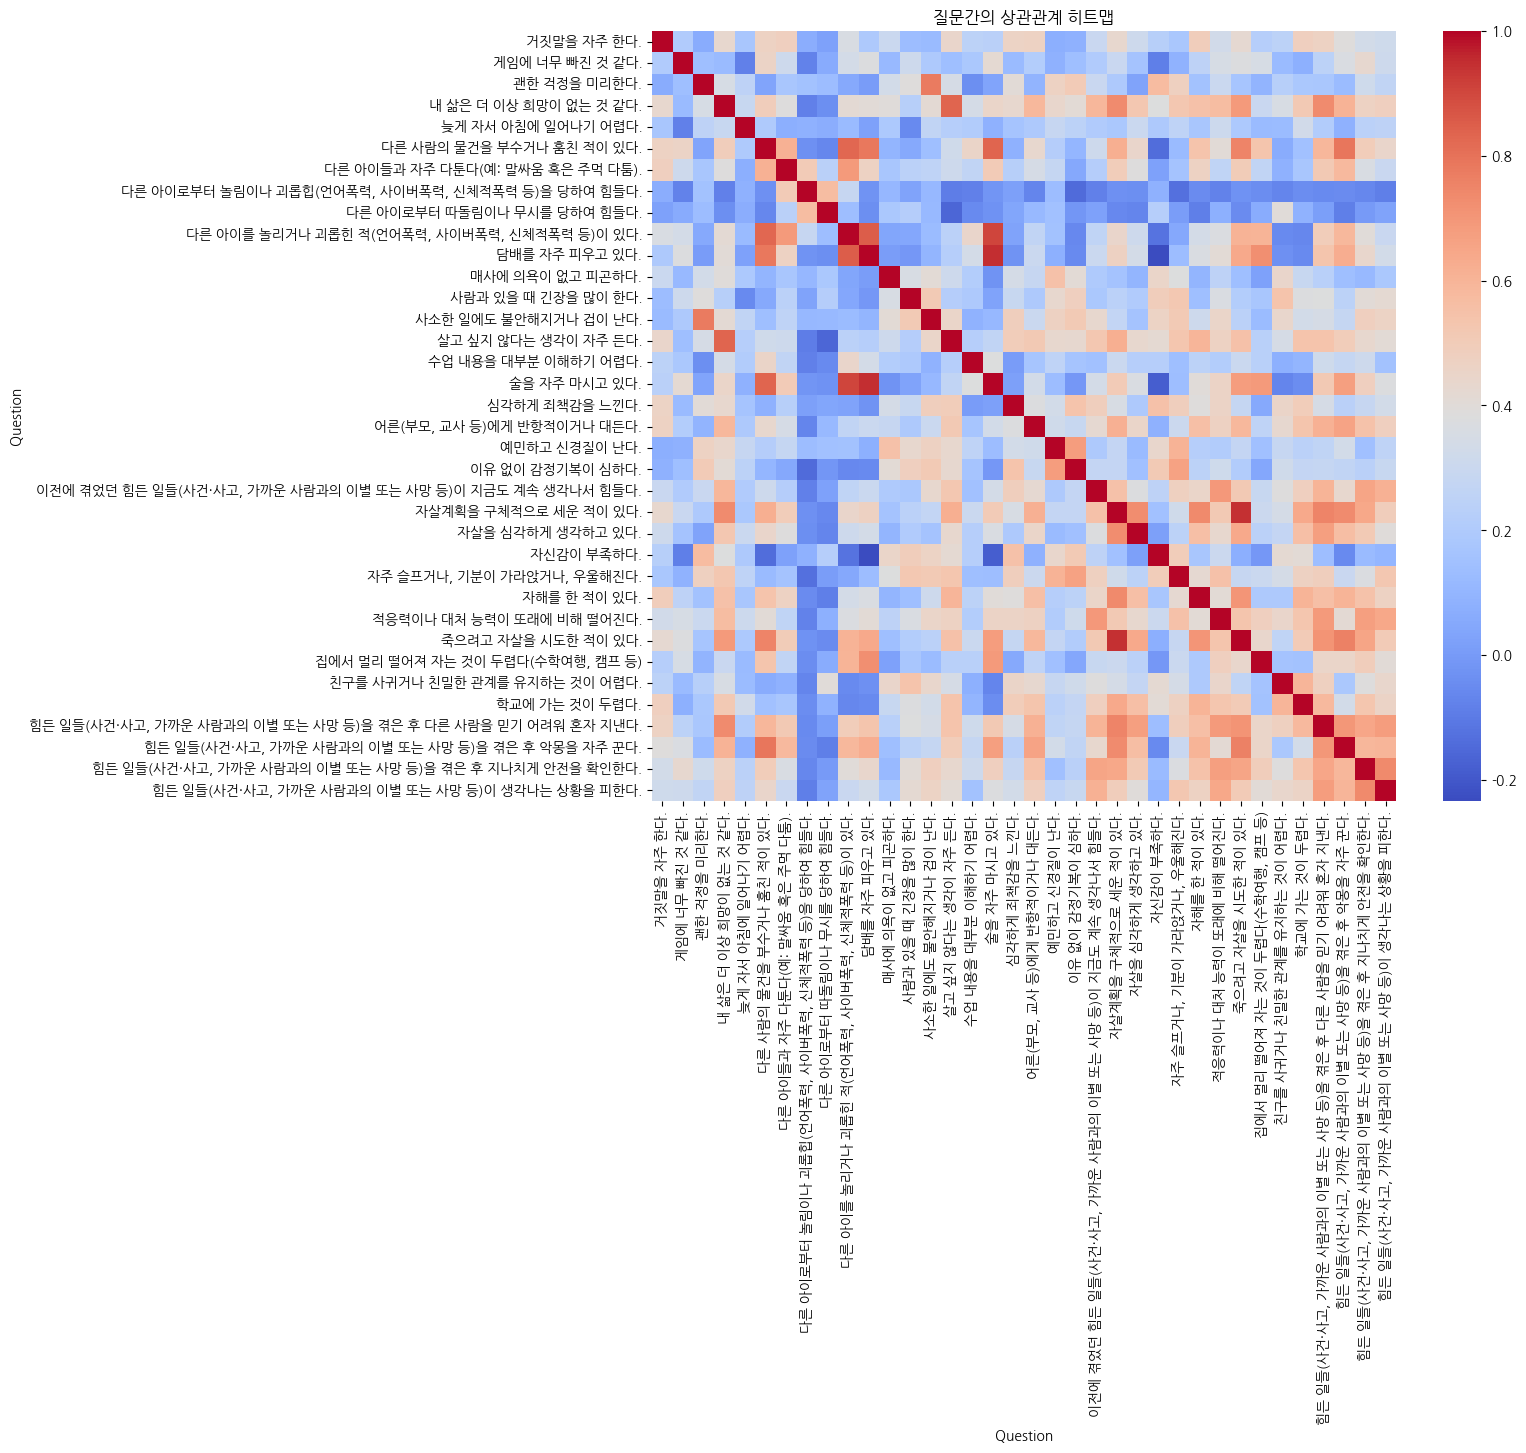

In [23]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("질문간의 상관관계 히트맵")
plt.show()


분류 대비 실제 질문 종류:
                                             Question  Cluster        Type
2                                        괜한 걱정을 미리한다.        0  불안 및 우울 문제
13                              사소한 일에도 불안해지거나 겁이 난다.        0  불안 및 우울 문제
1                                     게임에 너무 빠진 것 같다.        1      외현화 문제
0                                         거짓말을 자주 한다.        1      외현화 문제
5                           다른 사람의 물건을 부수거나 훔친 적이 있다.        1      외현화 문제
6                    다른 아이들과 자주 다툰다(예: 말싸움 혹은 주먹 다툼).        1      외현화 문제
7   다른 아이로부터 놀림이나 괴롭힙(언어폭력, 사이버폭력, 신체적폭력 등)을 당하여 힘들다.        1     심리외상 문제
3                              내 삶은 더 이상 희망이 없는 것 같다.        1  자살 및 위기 문제
15                               수업 내용을 대부분 이해하기 어렵다.        1   학교생활적응 문제
8                         다른 아이로부터 따돌림이나 무시를 당하여 힘들다.        1     심리외상 문제
10                                     담배를 자주 피우고 있다.        1      외현화 문제
9        다른 아이를 놀리거나 괴롭힌 적(언어폭력, 사이버폭력, 신체적폭력 등)이 있다.        1      외현화 문제
14      

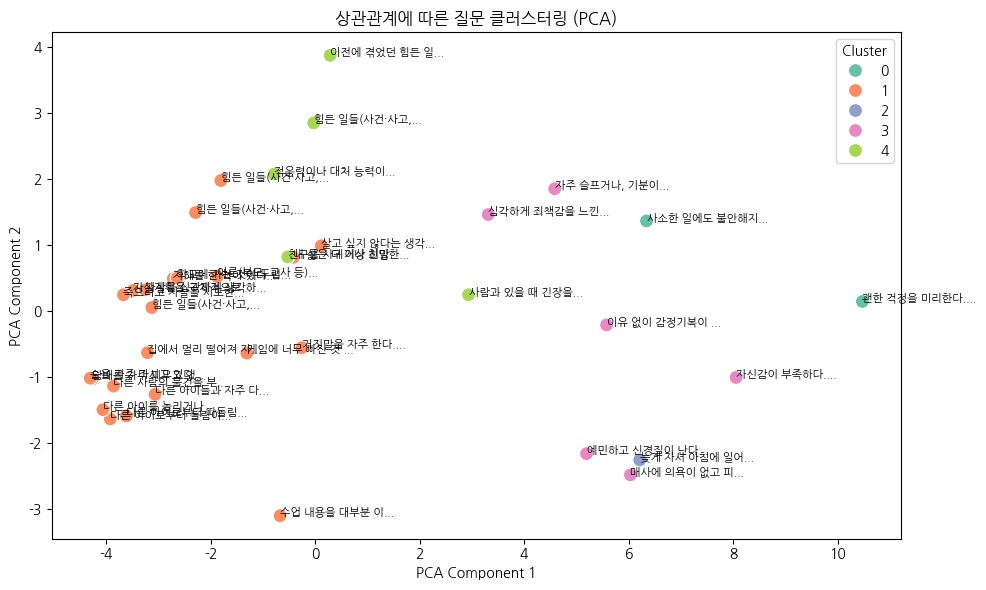

In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Pivot question_df into wide format (students × questions)
pivot_df = question_df.pivot(
    index="student_id", columns="Question", values="Answer")

# Step 2: Fill missing values (e.g., median or 0)
pivot_df_filled = pivot_df.fillna(pivot_df.median())

# Step 3: Transpose → Now rows = questions, columns = students
X = pivot_df_filled.T

# Step 4: Cluster questions using KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X)

# Step 5: Combine question names with cluster labels
question_clusters = pd.DataFrame({
    "Question": X.index,
    "Cluster": clusters
})

# Step 6: Add original type (category label)
original_types = question_df.drop_duplicates(subset=["Question"])[
    ["Question", "Type"]]
question_clusters = question_clusters.merge(
    original_types, on="Question", how="left")

# Print results
print("\n분류 대비 실제 질문 종류:")
print(question_clusters.sort_values("Cluster"))

# Step 7: Visualize with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=clusters, palette="Set2", s=100)
for i, q in enumerate(X.index):
    plt.text(X_pca[i, 0], X_pca[i, 1], q[:12] + "...", fontsize=8)

plt.title("상관관계에 따른 질문 클러스터링 (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Map each question to its assigned cluster
cluster_labels = question_clusters.set_index("Question")["Cluster"]
true_labels = question_clusters.set_index("Question")["Type"]

# Encode string labels (Type) to numeric for comparison
le = LabelEncoder()
true_labels_encoded = le.fit_transform(true_labels)

# Ensure both arrays are aligned
pred_clusters = cluster_labels.loc[true_labels.index].values

# Compute clustering metrics
ari = adjusted_rand_score(true_labels_encoded, pred_clusters)
nmi = normalized_mutual_info_score(true_labels_encoded, pred_clusters)

print(f"\n🔍 Adjusted Rand Index (ARI): {ari:.3f}")
print(f"🔍 Normalized Mutual Information (NMI): {nmi:.3f}")

# ARI 0.3 이하 약한 상관관계
# NMI 0.5 기존 질문의 분류 미흡


🔍 Adjusted Rand Index (ARI): 0.165
🔍 Normalized Mutual Information (NMI): 0.416
